In [2]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools

import pandas as pd
pd.options.mode.chained_assignment = None
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import itertools
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
import tempfile
import six
import networkx as nx
import scipy.stats as sps
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime
from matplotlib.colors import LogNorm

from scipy.stats import mode
dy_name = 'Figures_SV_Discovery'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    DJ.makedir(private_out)

import vapeplot

In [11]:
def plot_discordance_vs_cat(df,labels, colors, thresholds, num_sites, cat, letter_label, ax = False, 
                            cbar_ax = False):
    min_thresh = min(thresholds)
    max_thresh = max(thresholds)
    
    
    with sns.axes_style('ticks'):
        if ax == False: 
            fig, ax = plt.subplots(1,1, figsize = (8,5))
            divider = make_axes_locatable(ax)
            axDivY = divider.append_axes( 'right', size=0.2, pad= 0.1)
            cmap = plt.cm.PuBu
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_thresh, vmax=max_thresh))
            sm.set_array([]) 
            cbar = plt.colorbar(sm, cax = axDivY)
        else:
            fig = ax.get_figure()
        
        # color bar plotting

            cmap = plt.cm.PuBu
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_thresh, vmax=max_thresh))
            sm.set_array([]) 
            cbar = plt.colorbar(sm, cax = cbar_ax)
            cbar.set_ticks(thresholds)
        
#         patches = mpltools.get_legend_patches(labels, markeredgecolor=colors,
#                                      markerfacecolor='white', markeredgewidth=2, markersize=10)
        
         
        for c, l in zip(colors, labels):
            tdf = df[df.SVTYPE == l]
         
            ax.scatter(tdf[num_sites], tdf.mean_replication_rate,
                       c = tdf.thresh, cmap= cmap, lw = 1, edgecolor = c, label = l)
        
#         leg = ax.legend(handles = patches, bbox_to_anchor = (1,0), loc='lower right',ncol = 1,
#                              fontsize= 11, title = 'SVTYPE', frameon=True, borderaxespad=0)
#         leg.get_frame().set_facecolor('white')
#         leg.get_frame().set_edgecolor('black')
#         plt.setp(leg.get_title(), fontsize=12, color='Black')
        
        ax.set(ylabel = 'Ave. RR', xlabel = 'No. Total Sites')      
        return ax, cbar
        

In [3]:
def prep_filter_info_plot(df):
    df['NAME'] = df.index
    df.index.name = 'index'
    def lambda_fix_all_missing(x):
        if x == 'All Missing':
            return 0.0
        else:
            return float(x)
  
    df = df[df.Chr.isin(CM.normal_Chrs)]
    for i in ['ALTAF_hipsci_fib', 'ALTAF_ipscore']:
        df[i] = df[i].apply(lambda x: lambda_fix_all_missing(x))
#         df[i] = df[i].astype(float)    

    return df 

In [54]:
def plot_rr_rate_vs_filters(filt_df, labels, colors,labels_filtering, colors_filtering, num_sites, letter_label= '',
                            ax = False, legend = True, s= 150, lw = 2):
    
    colors_dict = dict(zip(labels_filtering, colors_filtering))
    with sns.axes_style('ticks'):
        
        if not ax:
            fig, ax = plt.subplots(1,1, figsize = (10,6))
            
        else:
            fig = ax.get_figure()
     
        
        
        if legend:
            
            divider = make_axes_locatable(ax)
            axDivY = divider.append_axes( 'right', size=1.6, pad= 0.1)
            patches = mpltools.get_legend_patches(labels_filtering, markerfacecolor=colors_filtering, markersize=10)
            leg = axDivY.legend(handles=patches, fontsize=11,mode = 'expand', title = 'Filter Categories', 
                                bbox_to_anchor = (0,0,1,1),loc='upper left',ncol=1, borderaxespad=0, frameon=True)

            plt.setp(leg.get_title(),fontsize=12, color='Black')
        
            leg.get_frame().set_facecolor('white')
            leg.get_frame().set_edgecolor('black')
            a = axDivY.add_artist(leg)
        
        for c, l in zip(colors, labels):
            df = filt_df[filt_df.SVTYPE == l]
            ax.scatter(df[num_sites], df.mean_replication_rate, 
                       c = df.color, alpha=0.9, lw = lw, s = s, edgecolor = c, label = l)
        
        if legend:
            patches = mpltools.get_legend_patches(labels, markeredgecolor=colors,
                                     markerfacecolor='white', markeredgewidth=2, markersize=10)

            leg2 = axDivY.legend(handles = patches, bbox_to_anchor = (0,0,1,1), loc='lower left',ncol = 1,
                                 fontsize= 11, title = 'SVTYPE', frameon=True, mode = 'expand', borderaxespad=0)
            plt.setp(leg2.get_title(), fontsize=12, color='Black')

            leg2.get_frame().set_facecolor('white')
            leg2.get_frame().set_edgecolor('black')

            ax.set(ylabel = 'mean replication rate', xlabel = 'no. variant sites after filtering')
            axDivY.set_axis_off()
        
        fig.text(0.05, 0.95, "{}".format(letter_label), horizontalalignment='center', verticalalignment='center', fontsize = 18, fontweight='bold')
        return ax

In [4]:
def generate_per_pair_summary(df):
    df = df.copy()
    if 'ID' in df.columns:
        df = df.drop('ID', axis = 1)
        
    df = df.apply(pd.value_counts).T.stack().to_frame('counts').reset_index()
    names = ['pair', 'category', 'counts']
    df.columns = names
    df = df.pivot_table(values = 'counts', index = 'pair', columns = ['category'])
    
    for c in df.columns:
        df[c] = df[c].fillna(0).astype(int)
    
    df['total_variants'] = df.CONCORDANT + df.DISCORDANT
    df['percent_concordant'] = df.CONCORDANT/ df.total_variants
    return df

In [5]:
def get_highest_rr_unique_pairs(rr_per_pair_summary_fib_ipsc):
    rr_per_pair_summary_fib_ipsc['PAIR'] = rr_per_pair_summary_fib_ipsc.index
    rr_per_pair_summary_fib_ipsc['P1'] = rr_per_pair_summary_fib_ipsc['PAIR'].apply(lambda x: x.split('_')[0])

    t = rr_per_pair_summary_fib_ipsc.groupby(['P1']).percent_concordant.describe()
    t['P1'] = t.index
    inds = t[t['count'] > 1].index.tolist()

    dfs = []
    for x, df in rr_per_pair_summary_fib_ipsc[rr_per_pair_summary_fib_ipsc.P1.isin(inds)].groupby('P1'):
        df = df[df.percent_concordant == df.percent_concordant.max()].head(1)
        dfs.append(df)

    tdf = pd.concat(dfs)

    best_pairs = pd.concat([rr_per_pair_summary_fib_ipsc[~rr_per_pair_summary_fib_ipsc.P1.isin(inds)], tdf])
    return  rr_per_pair_summary_fib_ipsc, best_pairs

In [247]:
def draw_barplot_rr_summary_horizontal(ax, rr_summary):
        
    orders = [['DEL', 'DUP', 'INV', 'rMEI', 'BND'], ['DEL', 'DUP', 'mCNV'], ['ALU', 'LINE1', 'SVA'], ['STR']]
    callers = ['SS', 'GS', 'MELT', 'HipSTR']
    cats = ['Unfiltered', 'Filtered']

    cats = ['Unfiltered', 'Filtered', 'De-Duplicated/Stitched', 'Stitch Sites', 'MC Sites', 'Non-Redundant']
    colors = ['#80ced6', '#618685', '#36486b','#ffef96', '#deeaee', '#b2b2b2']
    pal = dict(zip(cats, colors))
    ax.xaxis.grid(zorder = 0)
    rects1 = []
    errors1 = []
    rects2 = []
    errors2 = []
    count = 0
    for c in callers:
        tdf = rr_summary[(rr_summary.CALLER==c) & (rr_summary['stage'] == 'Filtered')]
        d = tdf.set_index('SVTYPE_NR').loc[orders[count]]['RR'].tolist()
        e = tdf.set_index('SVTYPE_NR').loc[orders[count]]['stdev'].tolist()
        rects2.append(d + [0])
        errors1.append(e + [0])
        
        tdf = rr_summary[(rr_summary.CALLER==c) & (rr_summary['stage'] == 'Unfiltered')]
        d = tdf.set_index('SVTYPE_NR').loc[orders[count]]['RR'].tolist()
        e = tdf.set_index('SVTYPE_NR').loc[orders[count]]['stdev'].tolist()
        rects1.append(d + [0])
        errors2.append(e + [0])
        count +=1

    barWidth = 0.35

    rects1 = CM.flatten_list(rects1)[:-1]
    rects2 = CM.flatten_list(rects2)[:-1]
    errors1 = CM.flatten_list(errors1)[:-1]
    errors2 = CM.flatten_list(errors2)[:-1]
    
    
    ticklabs = CM.flatten_list([i + [''] for i in orders])[:-1]

    r = np.arange(len(CM.flatten_list(orders)) + 3)
    ax.barh(r + barWidth, list(reversed(rects1)), height = barWidth,
            color = pal['Unfiltered'], zorder = 20, 
            label = 'Unfiltered')
    ax.barh(r, list(reversed(rects2)), height = barWidth, color = pal['Filtered'], zorder = 20, 
           label = 'Filtered')

    ax.set_yticks(r + barWidth/2)
    ax.set_yticklabels(list(reversed(ticklabs)))
    
    locs = list(reversed([0.5, 3, 7, 13]))
    labs = ['SS', 'GS', 'MELT', 'HipSTR']
#     labs = list(reversed(labs))
    for x, y in zip(locs, labs):
        ax.text(1.05, x, y)
        

    ax.set_xlim(min(ax.get_xlim()), 1.2)
    ax.set
    ax.set_xlabel('Ave. RR');

In [74]:
rr_twin_ss = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_qc_analysis/lumpy_filtering_MSQ_twin.pkl')

rr_ipsc_ss = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/ss_qc_analysis/lumpy_filtering_MSQ_fib_ipsc_filt.pkl')

In [75]:
rr_twin_gs = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis/gs_rr_MSQ_twins.pkl')

rr_ipsc_gs = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis/gs_rr_MSQ_ipsc_fib_filt.pkl')

In [91]:
rr_twins_melt = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/melt_rr_cat_twins.pkl')
rr_ipsc_melt = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/melt_rr_cat_ipsc.pkl')

In [249]:

rr_summary = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/figure_1_input/rr_summary.pkl')

rr_summary = rr_summary[~((rr_summary.SVTYPE_NR== 'mCNV') & (rr_summary.CALLER == 'SS'))]

In [133]:
thresholds_to_plot = ['lc', 'rSD', 'hDP', 's25', 'NO_FILTER', 'lc,hDP,rSD,s25']
thresholds_to_plot_sets = [set(i.split(',')) for i in thresholds_to_plot]
rr_ipsc_melt['to_plot'] = rr_ipsc_melt['thresh'].apply(lambda x: set(set(x)) in thresholds_to_plot_sets)
rr_twins_melt['to_plot'] = rr_twins_melt['thresh'].apply(lambda x: set(set(x)) in thresholds_to_plot_sets)

# Pallettes and ordering

In [80]:
color_pal_svtypes_all = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/Figures/color_pal_svtypes_all.pkl').to_dict()
color_pal_svtypes_all['all'] = 'black'

# Figure 

In [76]:
mpl.gridspec.rcParams['legend.handletextpad'] = 0.2
mpl.gridspec.rcParams['legend.columnspacing'] = 0.5
mpl.gridspec.rcParams['legend.labelspacing'] = 0.5
mpl.gridspec.rcParams['axes.labelpad'] = 2
mpl.gridspec.rcParams['axes.titlesize'] = 10
mpl.gridspec.rcParams['axes.labelsize'] = 10
mpl.gridspec.rcParams['ytick.labelsize'] = 8
mpl.gridspec.rcParams['xtick.labelsize'] = 8
mpl.gridspec.rcParams['axes.labelweight'] = 'bold'

In [ ]:
2

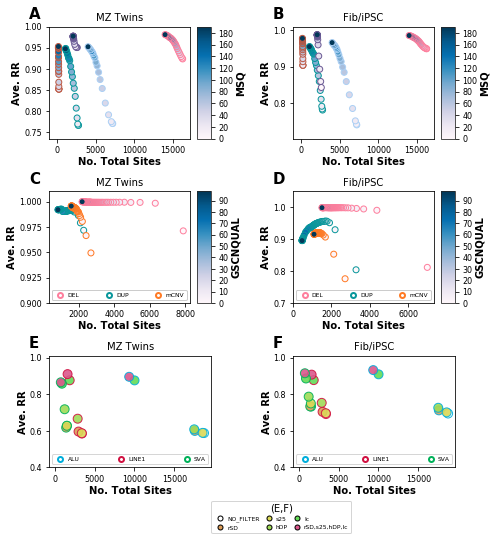

In [157]:
fig =plt.figure(figsize=(7,7))
gs = mpl.gridspec.GridSpec(3, 2, 
                           figure =fig,
                           width_ratios=[1, 1], height_ratios = [1, 1, 1], wspace = 0.5, hspace=0)


# ax1 = fig.add_subplot(gs[0,0])
# ax2 = fig.add_subplot(gs[0,1])
subgrid_ax1 = mpl.gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs[0,0],
                                               width_ratios=(1, 0.1), 
                                                   wspace=0.1, hspace= 0)
subgrid_ax2 = mpl.gridspec.GridSpecFromSubplotSpec(1,2, 
                                        subplot_spec=gs[0,1],
                                               width_ratios=(1, 0.1),
                                                   wspace=0.1, hspace= 0)

subgrid_ax3 = mpl.gridspec.GridSpecFromSubplotSpec(1,2, 
                                        subplot_spec=gs[1,0],
                                               width_ratios=(1, 0.1), 
                                                   wspace=0.1, hspace= 0)
subgrid_ax4 = mpl.gridspec.GridSpecFromSubplotSpec(1,2, 
                                        subplot_spec=gs[1,1],
                                               width_ratios=(1, 0.1),
                                                   wspace=0.1, hspace= 0)

subgrid_ax5 = mpl.gridspec.GridSpecFromSubplotSpec(1,2, 
                                        subplot_spec=gs[2,0],
                                               width_ratios=(1, 0.1),
                                                   wspace=0.1, hspace= 0)


subgrid_ax6 = mpl.gridspec.GridSpecFromSubplotSpec(1,2, 
                                        subplot_spec=gs[2,1],
                                               width_ratios=(1, 0.1),
                                                   wspace=0.1, hspace= 0)



ax1_a = fig.add_subplot(subgrid_ax1[0])
ax1_b = fig.add_subplot(subgrid_ax1[1])
ax2_a = fig.add_subplot(subgrid_ax2[0])
ax2_b = fig.add_subplot(subgrid_ax2[1])
ax3_a = fig.add_subplot(subgrid_ax3[0])
ax3_b = fig.add_subplot(subgrid_ax3[1])
ax4_a = fig.add_subplot(subgrid_ax4[0])
ax4_b = fig.add_subplot(subgrid_ax4[1])
ax5 = fig.add_subplot(subgrid_ax5[:])
ax6 = fig.add_subplot(subgrid_ax6[:])


# colors = ['#00aedb', '#d11141', '#00b159', '#f37735', '#5a5255', 'black']
labels = ['BND', 'DEL', 'DUP', 'INV', 'rMEI', 'all']
colors = [color_pal_svtypes_all[i] for i in labels]
thresholds_MSQ = list(np.arange(0, 200, 10))
ax1_a, cbar = plot_discordance_vs_cat(rr_twin_ss, labels[:-1], colors[:-1], thresholds_MSQ, 'num_sites_all', 'MSQ', 'A',
                             ax = ax1_a, cbar_ax=ax1_b)
cbar.ax.set_ylabel('MSQ')
thresholds_ticks = list(np.arange(0, 200, 20))
cbar.set_ticks(thresholds_ticks)

ax2_b, cbar = plot_discordance_vs_cat(rr_ipsc_ss, labels[:-1], colors[:-1], thresholds_MSQ, 'num_sites_all', 'MSQ', 'A',
                             ax = ax2_a, cbar_ax=ax2_b)
cbar.ax.set_ylabel('MSQ')
thresholds_ticks = list(np.arange(0, 200, 20))
cbar.set_ticks(thresholds_ticks)



labels = ['DEL','DUP', 'mCNV', 'all'][:-1]
colors = [color_pal_svtypes_all[i] for i in labels]
thresholds_gsnqual = list(np.arange(0, 100, 2))
ax3_a, cbar = plot_discordance_vs_cat(rr_twin_gs, labels, colors, 
                                      thresholds_gsnqual, 'num_sites_all', 
                                      'GSCNQUAL', 'A',
                             ax = ax3_a, cbar_ax=ax3_b)
cbar.ax.set_ylabel('GSCNQUAL')
thresholds_ticks = list(np.arange(0, 110, 10))
cbar.set_ticks(thresholds_ticks)

ax4_a, cbar = plot_discordance_vs_cat(rr_ipsc_gs, labels, colors, 
                                      thresholds_gsnqual, 'num_sites_all', 
                                      'GSCNQUAL', 'A',
                             ax = ax4_a, cbar_ax=ax4_b)

cbar.ax.set_ylabel('GSCNQUAL')
thresholds_ticks = list(np.arange(0, 110, 10))
cbar.set_ticks(thresholds_ticks)

ax3_a.set_ylim(0.9, 1.01)
ax4_a.set_ylim(0.7, 1.05)

yticks = np.arange(0.9, 1.02, 0.025)
ax3_a.set_yticks(yticks)
yticks = [0.7, 0.8, 0.9, 1.0]
ax4_a.set_yticks(yticks)
patches = mpltools.get_legend_patches(labels, markeredgecolor=colors,   
                                     markerfacecolor='white', 
                                      markeredgewidth=2, markersize=5)

leg = ax3_a.legend(handles = patches, bbox_to_anchor = (0,0, 1, 1), loc='lower left',
                 frameon=True, framealpha=1, fontsize=6, ncol =4, mode = 'expand')

leg = ax4_a.legend(handles = patches, bbox_to_anchor = (0,0, 1, 1), 
                   loc='lower left', frameon=True, framealpha=1, fontsize=6,
                   ncol =4, mode = 'expand')



labs_svtypes = ['ALU', 'LINE1', 'SVA','all']
colors_svtypes = ['#00aedb', '#d11141', '#00b159', 'black']
labels_filtering = ['NO_FILTER','rSD', 's25', 'hDP', 'lc', 'lc,hDP', 'rSD,hDP', 'lc,s25','rSD,lc', 'rSD,hDP,lc', 'hDP,lc,s25', 'rSD,hDP,s25' ,'rSD,s25,hDP,lc']



colors_filtering = sns.color_palette("hls", len(labels_filtering))
colors_filtering[0] = 'white'
color_dict = dict(zip(labels_filtering, colors_filtering))

labels_filtering = ['NO_FILTER','rSD', 's25', 'hDP', 'lc', 'rSD,s25,hDP,lc']
colors_filtering = [color_dict[i] for i in labels_filtering]
# categories = [i.split(',') for i in subset] 


ax5 = plot_rr_rate_vs_filters(rr_twins_melt[rr_twins_melt.to_plot],
                                            labs_svtypes[:-1], colors_svtypes[:-1], 
                              labels_filtering, colors_filtering, 
                              'num_sites_all', letter_label='', ax = ax5, 
                              legend = False, s = 80, lw = 1)

ax6 = plot_rr_rate_vs_filters(rr_ipsc_melt[rr_ipsc_melt.to_plot], labs_svtypes[:-1], colors_svtypes[:-1], 
                              labels_filtering[:-1], colors_filtering[:-1], 
                              'num_sites_all', letter_label='', ax = ax6, 
                              legend = False, s = 80, lw = 1)
# draw legends for top row

patches = mpltools.get_legend_patches(labs_svtypes[:-1], 
                                      markeredgecolor=colors_svtypes[:-1],
                                     markerfacecolor='white', 
                                      markeredgewidth=2, markersize=5)

leg = ax5.legend(handles = patches, fontsize=6, mode = 'expand', ncol = 4, 
                  bbox_to_anchor = (0,0, 1, 1), loc = 'lower left')
a = ax5.add_artist(leg)
leg2 = ax6.legend(handles = patches, fontsize=6, mode = 'expand', ncol = 4, 
                  bbox_to_anchor = (0,0, 1, 1), loc = 'lower left')
ax5.set_ylim(0.4, 1.01)
ax6.set_ylim(ax5.get_ylim())

for a in [ax5, ax6]:
    a.set_ylabel('Ave. RR')
    a.set_xlabel('No. Total Sites')
    
    
for a in [ax1_a, ax2_a, ax3_a, ax4_a, ax5, ax6][::2]:
    a.set_title('MZ Twins')
    
for a in [ax1_a, ax2_a, ax3_a, ax4_a, ax5, ax6][1::2]:
    a.set_title('Fib/iPSC')
gs.tight_layout(fig)


patches = mpltools.get_legend_patches(labels_filtering, markerfacecolor=colors_filtering, markersize=5)
leg = ax5.legend(handles=patches, fontsize=6,
                                bbox_to_anchor = (1, -0.3),loc='upper left',ncol=3, borderaxespad=0, frameon=True, title = '(E,F)')
# a = ax5.add_artist(leg)


labels = ['A', 'B', 'C', 'D', 'E', 'F']
for i, a in enumerate([ax1_a, ax2_a, ax3_a, ax4_a, ax5, ax6]):
    mpltools.label_offset_axes(a, fig, labels[i],
                               x = -20, y = 8)

out_fn = private_out + '/Figure_RR_vs_Qual_Metrics'
fig.savefig(out_fn, bbox_inches='tight', dpi = 200)

